## WY2017 temp increase (wet and warm year)
- Save out SWE and saturation for the full WY
- Calculate evaporative fraction for the full WY
- Save out summer subsurface storage
- Save out summer transpiration
- Save out summer recharge

In [2]:
import os
import sys
from parflow.tools import Run
from parflow.tools.fs import mkdir, cp, get_absolute_path, exists
from parflow.tools.settings import set_working_directory
from parflow.tools.io import read_pfb,write_pfb, read_clm
import parflow.tools.hydrology as hydro
import parflow as pf
from parflow import Run

from glob import glob
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import calendar
from matplotlib import colors 
import matplotlib.dates as mdates

In [3]:
"""
Creating the run object from the pdifb and getting grid size and shape. 
Then creating data accessor object ("data = ...")
"""
runname = 'East_taylor_1.5inc_wy2003IC.wy2017'
run_dir=''
run_dir = get_absolute_path(runname)

path_run = f'/hydrodata/temp/EastTaylor_ashley/{runname}/'

run = Run.from_definition(f'{path_run}{runname}.pfidb')
run.Solver.CLM.MetFilePath = '~/EastTaylor_inputs/newbounds_1.5CW3E_WY2017' # forcing

data = run.data_accessor # creating data accessor object 
dx = data.dx
dy = data.dy
dz = data.dz
nz,ny,nx = data.shape

porosity= data.computed_porosity
specific_storage = data.specific_storage
mask = data.mask
mask[mask>0]=1 # PF has big # instead of 1 so change to 1 bc more manageable
surf_mask = mask[-1,:,:] # last element of first axis (always be surface no matter what)


# Mannings not always printed as outputm so it's a special case
if run.Mannings.Type == 'PFBFile':
    mannings = np.squeeze(read_pfb(f'{path_run}{run.Mannings.FileName}'))
elif run.Mannings.Type == 'Constant':
    mannings = run.Mannings.Geom.domain.Value
slopex = np.squeeze(data.slope_x)
slopey = np.squeeze(data.slope_y)

# for converting from LE to ET
rho_w = 1000 # kg/m3
hvap   = 2.5104e06 

print(dx, dy)
nanmask=mask.copy()
nanmask[nanmask == 0] = 'NaN'
nanmask[nanmask > 0] = 1

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


1000 1000


In [6]:
# """
# Reading CLM Outputs:
# """
# eflx_lh_tot = data.clm_output('eflx_lh_tot') # latent heat flux total [W/m2] using silo variable LatentHeat - ACTUALLY USE THIS AND CONVERT TO PLOT TOTAL ET (next line)
# #e_mm_s = eflx_lh_tot*(1/rho_w)*(1/h_vap)*1000

# eflx_lwrad_out  = data.clm_output('eflx_lwrad_out') #  outgoing long-wave radiation [W=m2] using the silo variable LongWave;
# eflx_sh_tot  = data.clm_output('eflx_sh_tot') #  sensible heat flux total [W/m2] using the silo variable SensibleHeat;
# eflx_soil_grnd  = data.clm_output('eflx_soil_grnd') #  ground heat flux [W/m2] using the silo variable GroundHeat;
# qflx_evap_tot  = data.clm_output('qflx_evap_tot') #  total evaporation [mm/s] using the silo variable EvaporationTotal;
# qflx_evap_grnd  = data.clm_output('qflx_evap_grnd') #  ground evaporation without condensation [mm=s] using the silo variable EvaporationGround-NoSublimation;
# qflx_evap_soi  = data.clm_output('qflx_evap_soi') #  soil evaporation [mm/s] using the silo variable EvaporationGround;
# qflx_evap_veg  = data.clm_output('qflx_evap_veg') #  vegetation evaporation [mm/s] using the silo variable EvaporationCanopy;
#qflx_tran_veg  = data.clm_output('qflx_tran_veg') #  vegetation transpiration [mm/s] using the silo variable Transpiration;
# qflx_infl  = data.clm_output('qflx_infl') #  soil infiltration [mm/s] using the silo variable Infiltration;
# swe_out  = data.clm_output('swe_out') #  snow water equivalent [mm] using the silo variable SWE;
# t_grnd  = data.clm_output('t_grnd') #  ground surface temperature [K] using the silo variable TemperatureGround; and
# t_soil  = data.clm_output('t_soil') #  soil temperature over all layers [K] using the silo variable TemperatureSoil.
# qflx_evap_tot.shape


## SWE and sat

In [4]:
year = 2017
if calendar.isleap(year) == False:

    num_tsteps = 8760+1
else: 
    num_tsteps = 8784+1

In [4]:
"""
getting storage and fluxes

only run once to save out arrays, load in the next cell
"""

year = 2017
if calendar.isleap(year) == False:

    num_tsteps = 8760+1
else: 
    num_tsteps = 8784+1
# tstep_range = np.arange(0,8760,24)
# num_tsteps = len(tstep_range)

et_sum = np.zeros(num_tsteps)
precip = np.zeros(num_tsteps)
swe = np.zeros(num_tsteps)


# for t in range(num_tsteps):
for t in range(0,num_tsteps):
    
    # tstep_range[-1]
    data.time = t
                                
    if t > 0: 
        data.forcing_time = t-1
        swe[t]  = np.sum(data.clm_output('swe_out')[surf_mask==1])#*(1/1000)*(dx)*(dy)
    
np.save("swe_wy2017_warm", swe)


In [5]:
# reading in swe by point
year = 2017
if calendar.isleap(year) == False:

    num_tsteps = 8760+1
else: 
    num_tsteps = 8784+1

swe_bypixel = np.zeros((num_tsteps, ny, nx))

for t in range(0,num_tsteps):
    data.time = t
            
    if t > 0: 
        swe_bypixel[t, :, :]  = data.clm_output('swe_out')

np.save("swe_bypixel_warm", swe_bypixel)

swe_bypixel.shape

(8761, 48, 67)

In [6]:
swe_bypixel = np.load("swe_bypixel_warm.npy")
swe_bypixel = swe_bypixel*(1/1000)*dx*dy


In [26]:
sat_10cm = np.zeros((num_tsteps, ny, nx)) 
sat_40cm = np.zeros((num_tsteps, ny, nx)) 
sat_1m = np.zeros((num_tsteps, ny, nx))

for t in range(0, num_tsteps):
    data.time = t

    sat_10cm[t] = data.saturation[9,:,:]
    sat_40cm[t] = data.saturation[8,:,:]
    sat_1m[t] = data.saturation[7,:,:]

np.save("sat_10cm_warm", sat_10cm)
np.save("sat_40cm_warm", sat_40cm)
np.save("sat_1m_warm", sat_1m)

## Evaporative Fraction (ET/P) over the whole water year

In [9]:
# calculating total precip and et at each cell
precip_tot = np.zeros((ny,nx))
et_tot = np.zeros((ny,nx))

num_tsteps = 8760+1

 # 2d array for precip at particular timestep for each cell
precip_timestep = np.zeros((ny,nx))
et_timestep = np.zeros((ny,nx))

for t in range(0,num_tsteps):
    data.time = t

    
    if t > 0: 
        data.forcing_time = t-1
        # 2d array for that particular timestep
        precip_timestep= data.clm_forcing_apcp*3600

        # array of the cumulative precip at each grid cell
        precip_tot += precip_timestep


        et_timestep = data.clm_output('eflx_lh_tot') * (1 / rho_w) * (1 / hvap)*3600*1000  # converting from m/s to mm/hr 

        et_tot += et_timestep

np.save("precip_tot", precip_tot)
np.save("domain_et_tot_warm", et_tot)

In [10]:
precip_tot = np.load("precip_tot.npy")
yr_et_tot = np.load("domain_et_tot_warm.npy")

In [18]:
precip_tot = precip_tot*nanmask
yr_et_tot = yr_et_tot*nanmask

In [21]:
precip_tot_domain = np.nansum(precip_tot)
precip_tot_domain

yr_et_tot_domain = np.nansum(yr_et_tot)
yr_et_tot_domain

np.float64(9072879.059828287)

In [24]:
evap_frac = yr_et_tot_domain / precip_tot_domain
evap_frac

np.float64(0.6615370497027979)

## Subsurface storage across root zone layers

In [18]:
# 273 days between 10/1/2002 and 7/1/2003
# 62 days until 9/1/2003 from the start of july

summer_tstart = 273*24 # hour in the WY that july starts
summer_tend = (273+62)*24 # hour marking the start of september
summer_numtsteps = summer_tend - summer_tstart + 1

In [19]:
press_files = glob(f'{run_dir}*out.press*.pfb')
pressure_arrays = pf.read_pfb_sequence(press_files) * nanmask

#list all saturation files from outputs
satur_files = glob(f'{run_dir}*out.satur*.pfb')
#read in all sat files into a 3D NParray
saturation_arrays = pf.read_pfb_sequence(satur_files) * nanmask

subsurf_storage_bylayer = np.zeros((summer_numtsteps, nz, ny, nx))

for i in range(summer_numtsteps):
    data.time = i + summer_tstart # first index will be first hour of july
    subsurf_storage_bylayer[i, :,:,:] = hydro.calculate_subsurface_storage(porosity, pressure_arrays[i + summer_tstart,:,:,:], saturation_arrays[i + summer_tstart,:,:,:], data.specific_storage, dx, dy, dz, mask = nanmask)

np.save('subsurf_storage_bylayer_warm', subsurf_storage_bylayer)

## Summer transpiration

In [1]:
# 273 days between 10/1/2002 and 7/1/2003
# 62 days until 9/1/2003 from the start of july

summer_tstart = 273*24 # hour in the WY that july starts
summer_tend = (273+62)*24 # hour marking the start of september
summer_numtsteps = summer_tend - summer_tstart + 1

In [5]:
# arrays to hold soil moisture values at each time for each grid cell at varying depths
summer_sm_10cm = np.zeros((summer_numtsteps, ny, nx)) 
summer_sm_40cm = np.zeros((summer_numtsteps, ny, nx)) 
summer_sm_1m = np.zeros((summer_numtsteps, ny, nx)) 
summer_sm_2m = np.zeros((summer_numtsteps, ny, nx)) 
summer_sm_7m = np.zeros((summer_numtsteps, ny, nx)) 

# arrays to hold cumulative transpiration at each grid cell
summer_tran_sum = np.zeros((ny, nx))

# cumulative ground infiltration at each grid cell over the summer
summer_infl_sum = np.zeros((ny, nx))

# looping over july-september
for t in range(0, summer_numtsteps):
    data.time = t + summer_tstart # first index will be first hour of july

    # soil moisture (VWC) at each time step for each grid cell
    summer_sm_10cm[t] = data.saturation[9,:,:]*porosity[9,:,:] 
    summer_sm_40cm[t] = data.saturation[8,:,:]*porosity[8,:,:] 
    summer_sm_1m[t] = data.saturation[7,:,:]*porosity[7,:,:] 
    summer_sm_2m[t] = data.saturation[6,:,:]*porosity[6,:,:] 
    summer_sm_7m[t] = data.saturation[5,:,:]*porosity[5,:,:] 

    
    # 2d arrays for transpiration at that particular timestep
    tran_timestep = data.clm_output('qflx_tran_veg') * 3600  # converting from mm/s to mm/hr

    #total t for each grid cell
    summer_tran_sum += tran_timestep


    # 2d infiltration array for that particular timestep
    infl_timestep = data.clm_output('qflx_infl')*3600 # converting from mm/s to mm/hr

    # total infiltration for each grid cell
    summer_infl_sum += infl_timestep



np.save("summer_sm_10cm_warm", summer_sm_10cm)
np.save("summer_sm_40cm_warm", summer_sm_40cm)
np.save("summer_sm_1m_warm", summer_sm_1m)
np.save("summer_sm_2m_warm", summer_sm_2m)
np.save("summer_sm_7m_warm", summer_sm_7m)

np.save("summer_tran_sum_warm", summer_tran_sum)

np.save("summer_infl_sum_warm", summer_infl_sum)

In [5]:
summer_sm_10cm = np.load("summer_sm_10cm_warm.npy")
summer_sm_40cm = np.load("summer_sm_40cm_warm.npy")
summer_sm_1m = np.load("summer_sm_1m_warm.npy")
summer_sm_2m = np.load("summer_sm_2m_warm.npy")
summer_sm_7m = np.load("summer_sm_7m_warm.npy")

summer_tran_sum = np.load("summer_tran_sum_warm.npy")

summer_infl_sum = np.load("summer_infl_sum_warm.npy")


101.8497650770967
181.85183668778959
24.191013845956707


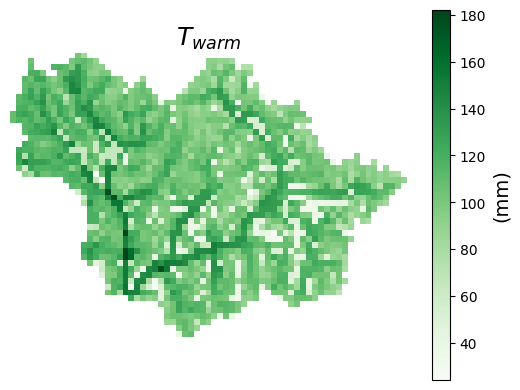

In [6]:
summer_tran_sum = np.load("summer_tran_sum_warm.npy")
plt.imshow(np.ma.masked_array(summer_tran_sum, surf_mask==0),origin='lower', cmap = 'Greens')
cbar = plt.colorbar()
plt.axis('off')
plt.title('$T_{warm}$', fontsize = 18)
cbar.set_label('(mm)', fontsize = 14)  # Set the label for the colorbar
basin_avg_t = np.nanmean(summer_tran_sum*nanmask)
print(basin_avg_t)
print(np.nanmax(summer_tran_sum*nanmask))
print(np.nanmin(summer_tran_sum*nanmask))

## Summer recharge

In [6]:
# finding area of basin with positive I-T (recharge area)
# each pixel is 1km, so can just sum pixels

diff_infil_T = (summer_infl_sum - summer_tran_sum)*nanmask[0]

recharge_area = 0
for y in range (0, ny):
    for x in range (0,nx):
        if diff_infil_T[y,x] >= 0:
            recharge_area +=1

print(recharge_area)
np.save("diff_infil_T_warm", diff_infil_T)

467


In [10]:
print(np.nanmin(diff_infil_T))
print(np.nanmax(diff_infil_T))

-120.84551018067151
110.75819156493795


(48, 67)

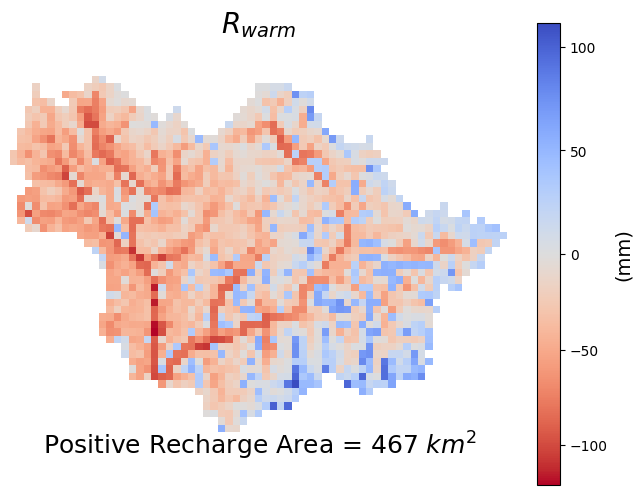

In [12]:
# how much water that infiltrates is transpired?
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

norm = colors.TwoSlopeNorm(vmin = np.nanmin(diff_infil_T), vcenter=0, vmax=111.55531418416751) # max from baseline simulation

im = ax.imshow(np.ma.masked_array(diff_infil_T, surf_mask==0),origin='lower', norm = norm,cmap='coolwarm_r')
ax.axis('off')
#fig.colorbar(ax.imshow(np.ma.masked_array(diff_infil_T, surf_mask==0),origin='lower', norm = norm, cmap = 'coolwarm_r'), ax=ax)
ax.set_title('$R_{warm}$', fontsize = 20, y = 1.1)
ax.text(4, -3.5, f"Positive Recharge Area = {recharge_area} $km^2$", fontsize = 18)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('(mm)', fontsize=14)
diff_infil_T.shape
